<h1>Introduction</h1>
<img  src="https://upload.wikimedia.org/wikipedia/commons/a/a6/Dipole_xmting_antenna_animation_4_408x318x150ms.gif" align='right' alt="radio">
This notebook will explore using deep learning for radio signal classificaiton. <br><br>
Here is a link to the paper we referenced: <br> <a href="https://arxiv.org/pdf/1712.04578.pdf">Deep Learning for Signal Classification</a>
<br> <br>
The goal is to autonomously label radio data. This is useful in many applications including interference monitoring, radio fault detection, dynamic spectrum access, opportunistic mesh networking, many others. In the past 5 years, we have seen rapid disruption to this field from improvements in deep learning. Deep learning has increased the capacity for learning features directly  on raw high dimensional input data based on high level supervised objectives.

# Import Modules

In [17]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import h5py

# Getting and Loading the Data
<div style="color:red;">
In order for deep learning classificaiton to work well, we need a lot of labeled training data.</div> 
You can download the labeled dataset of 2.5 million radio signals at: 
<a href="https://www.deepsig.io/datasets">Signal Dataset</a>

In [18]:
filename = 'sig_data/signals.hdf5'     # load the dataset
f = h5py.File(filename, 'r')
keys = list(f.keys())
print('Dataset Loaded!', '\n')

signals = []
labels = []

i = 1                                  # sample a radio signal of each class.
while i < 2555904:
    signal = f[keys[0]][i]
    label = f[keys[1]][i]
    signals.append(signal)
    labels.append(label)
    i = i + 110000

Dataset Loaded! 



# Display Raw Signal Data
The signals are stored in <a href="http://whiteboard.ping.se/SDR/IQ">I/Q form</a>. <br><br> I/Q data is a signal representation much more precise than just using a series of samples of the momentary amplitude of the signal. Here is some example output of one of the signals:

In [19]:
print('Data Type: ', type(signals[0]))

size = signals[0].shape
print('Data Shape: ', size, "\n")

print("Data Example:")
print(signals[0])
print('')

Data Type:  <class 'numpy.ndarray'>
Data Shape:  (1024, 2) 

Data Example:
[[ 1.198624    0.4493616 ]
 [ 0.48543093  0.28272954]
 [ 0.8679219  -0.33194578]
 ...
 [-1.2129315  -0.64293194]
 [-0.38100415  0.793629  ]
 [ 0.0864124   1.0921808 ]]



# Identify Classes of Signals
Each of the 2.5 million signals is classified as one of the following signal types:

In [20]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

# Display Signal Data in Wave Form
Here are 24 of the signals plotted out in visual wave form:

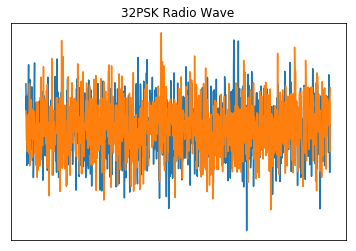

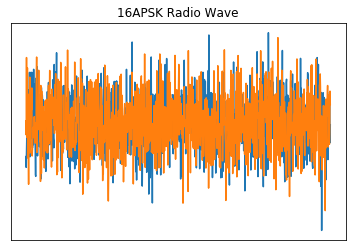

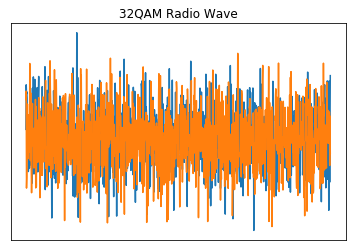

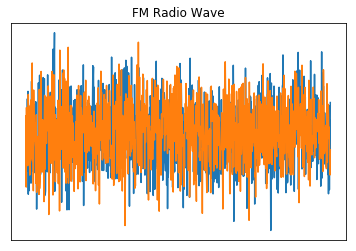

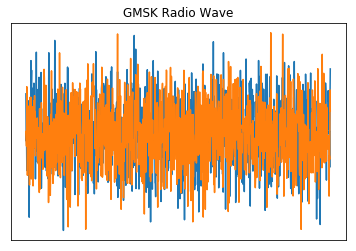

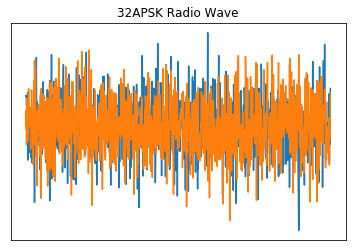

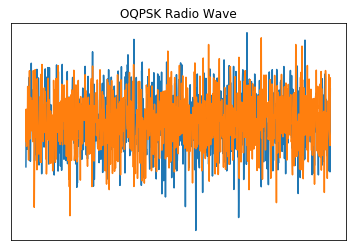

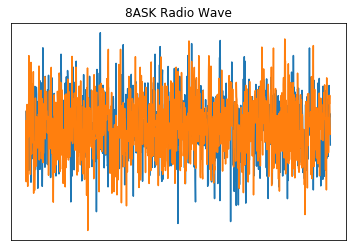

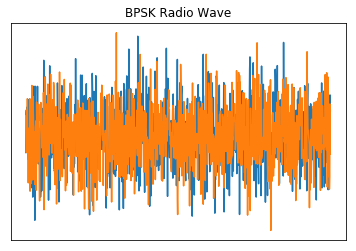

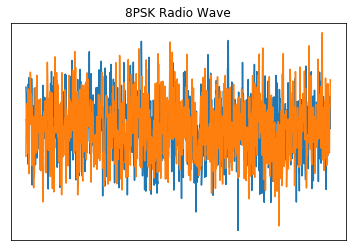

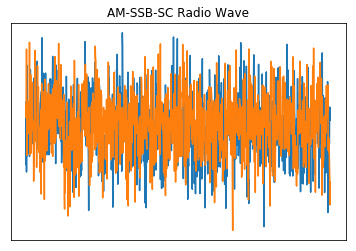

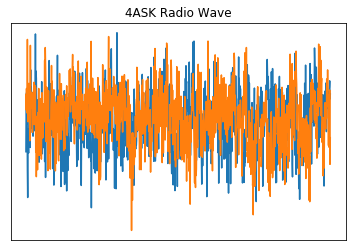

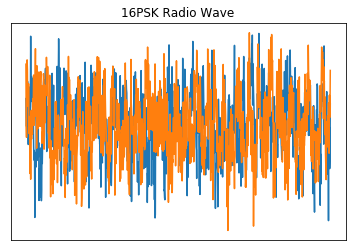

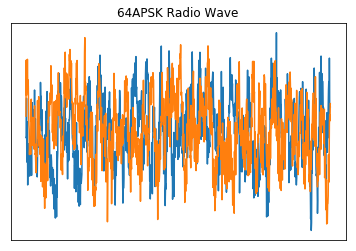

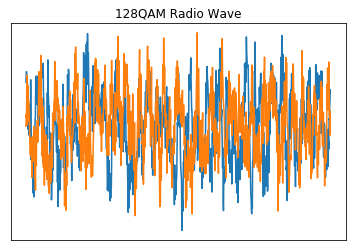

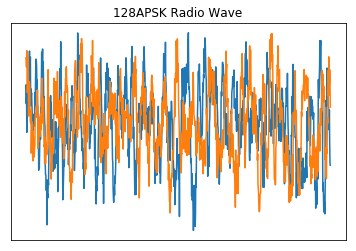

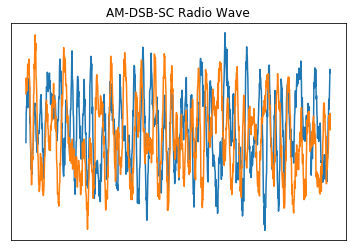

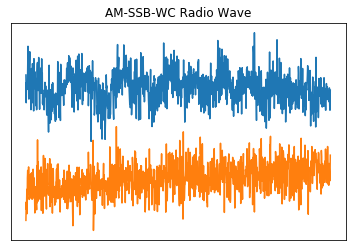

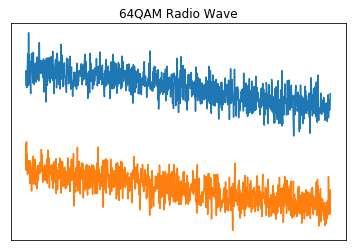

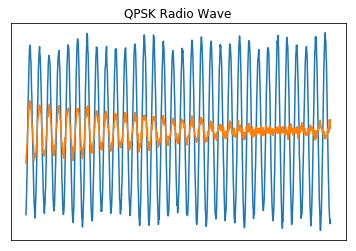

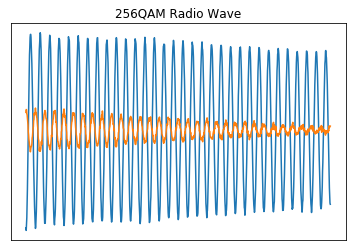

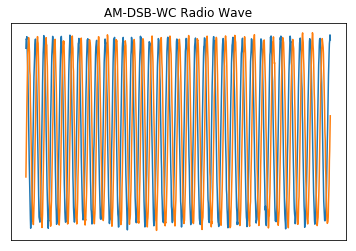

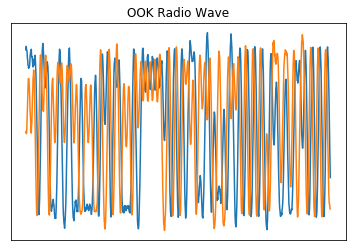

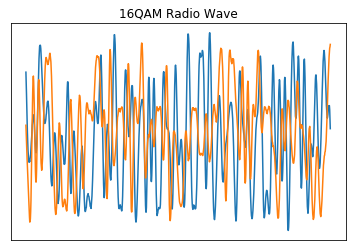

In [21]:
t = []
for i in range(1024):
    t.append(i)
    
for j in range(len(signals)):
    #print('Signal Example', j + 1)
    first = signals[j][:,0]
    second = signals[j][:,1]
    plt.plot(t, first)
    plt.plot(t, second)
    wave_type = classes[j]
    title = wave_type + ' Radio Wave'
    plt.title(title)
    xmax = 1024
    ymax = max([max(first),max(second)])
    plt.xticks([])
    plt.yticks([])
    plt.show()

<h1>What are Residual Networks (ResNet)?</h1>

A ResNet is a CNN architecture which can support hundreds or more convolutional layers.
ResNets can have many layers and still achieve good performance. ResNet proposes a solution to the "vanishing gradient" problem. When more layers are added, repeated multiplication of their derivatives eventuallymakes the gradient 	infinitesimally small, meaning additional layers won’t improve 
the performance or can even reduce it. ResNet solves this using “identity shortcut connections” – layers that initially don’t do anything. In the training process, these identical layers are skipped, reusing the 
activation functions from the previous layers. This reduces the network into only a few layers, which speeds learning. When the network trains again, the identical layers expand and help the network explore more of the feature space.

<h1>Import Deep Learning Libraries</h1>

In [22]:
import tensorflow
import keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import seaborn as sns

<h1>Load the Data Into Signals and Labels</h1>

In [23]:
signals = []
labels = []
data_sample = .0001
#data_sample = float(input('What percent of the data would you like to sample?:'))
total = 2555904 * data_sample
total = int(total)
multiplier = int(2555900/total)
last_answer = 0.0
for i in range(total):
    answer = (i/total)*100
    answer = round(answer,2)
    if last_answer != answer:
        clear_output()
        display('Data Loaded: ' + str(answer) + '%')
        last_answer = answer
    signal = f[keys[0]][i*multiplier]
    label = f[keys[1]][i*multiplier]
    signals.append(signal)
    labels.append(label)
clear_output()
display('Data Loaded: 100%')
print('Data Load Complete: ', len(signals), ' Signals and Labels Loaded!')

'Data Loaded: 100%'

Data Load Complete:  255  Signals and Labels Loaded!


<h1>Partition Data into Training and Testing Data</h1>
Here we partition the data into training and testing sets:

In [24]:
np.random.seed(2016)
train_sample = 0.8                                                             # choose number of training samples
n_train = total * train_sample
n_train = int(n_train)

train_idx = list(np.random.choice(range(0,total), size=n_train, replace=False))# randomly select training data
test_idx = list(set(range(0,total))-set(train_idx))                            # left over data = testing data

X_train = []
Y_train = []
for i in range(len(train_idx)):
    X_train.append(signals[train_idx[i]])
    Y_train.append(labels[train_idx[i]])

X_test =  []
Y_test = []
for i in range(len(test_idx)):
    X_test.append(signals[test_idx[i]])
    Y_test.append(labels[test_idx[i]])

print('Data has been split into training and testing data! \n')
print('Number of training examples: ',len(X_train))
print('Number of testing examples: ',len(X_test))

Data has been split into training and testing data! 

Number of training examples:  204
Number of testing examples:  51


<h1>Build the Neural Network Model</h1>
• Here we will build a VT-CNN2 Neural Network using Keras <br>
• We will reshape the data on input <br>
• Pass through two 2-dimensional conv/ReLU layers <br>
• Pass through two dense layers (RelU and Softmax) <br>
• Perform categorical cross entropy optimization

In [25]:
in_shp = list(X_train[1:])
dr = 0.5                                             # set dropout rate (%)

model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))   # reshape input data
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 2, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

TypeError: Error converting shape to a TensorShape: only size-1 arrays can be converted to Python scalars.